In [31]:
import os, io
from pathlib import Path
import math
from collections import defaultdict
from itertools import chain
import sqlite3

from tqdm.notebook import tqdm
from PIL import Image, ImageFilter, ImageEnhance, ImageDraw, ImageOps

import numpy as np
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt

from utils import *
from hdc import *

In [32]:
config = Config('SQLITE3')
RNG = np.random.default_rng()

if cp.cuda.is_available():
    device_marker = cp.empty(1)
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    device_marker = np.empty(1)
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    
xp = cp.get_array_module(device_marker)
print(f'xp = {xp.__name__}')

xp = cupy


In [33]:
def ensure_dataset_folder():
    if not os.path.exists(config.dataset_path):
        print(f'Creating "{config.dataset_path}"')
        os.mkdir(config.dataset_path)

def is_table_exists(db_con, table_name):
    df = pd.read_sql('SELECT name FROM sqlite_master WHERE type=:type AND name=:table_name', params={'type': 'table', 'table_name': table_name}, con=db_con)
    return len(df) > 0

ensure_dataset_folder()

if 0 == 1:
    print(f'Cleaning "{config.dataset_path}"')
    removed = []
    
    for fn in os.listdir(config.dataset_path):
        if fn.endswith(".db"):
            fn = os.path.join(config.dataset_path, fn)
            os.remove(fn)
            removed.append(fn)

    print(f'Removed .db files: {','.join(removed)}')

hdv_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.hdv_db_file_name), autocommit=False)
train_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.train_db_file_name), autocommit=False)
test_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.test_db_file_name), autocommit=False)

In [34]:
dataset_source = os.path.join(config.dataset_source)

In [35]:
import struct
from array import array

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        
        images = []
        
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images.append(img)
        
        return np.array(images), np.array(labels)
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)     

CPU times: user 221 ms, sys: 78.1 ms, total: 299 ms
Wall time: 298 ms


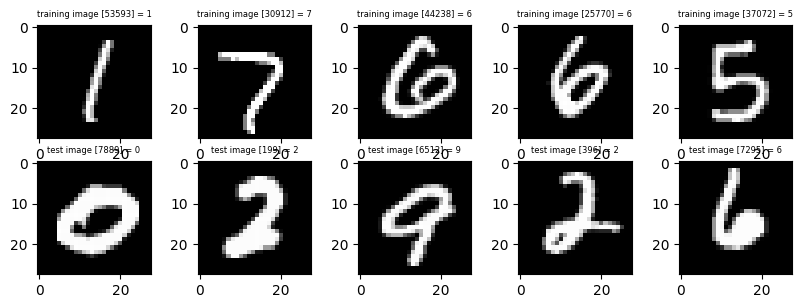

In [36]:
%%time
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
training_images_filepath = os.path.join(dataset_source, 'train-images-idx3-ubyte')
training_labels_filepath = os.path.join(dataset_source, 'train-labels-idx1-ubyte')
test_images_filepath = os.path.join(dataset_source, 't10k-images-idx3-ubyte')
test_labels_filepath = os.path.join(dataset_source, 't10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(10,5))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 6);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 5):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [37]:
SENSOR_RECEPTIVE_FIELD_SIZE = 8
SENSOR_RECEPTIVE_FIELD_SQUARE = SENSOR_RECEPTIVE_FIELD_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE
SENSOR_GROUP_SIZE = 4
SENSOR_GROUP_SQUARE = SENSOR_GROUP_SIZE * SENSOR_GROUP_SIZE
RETINA_SIZE = 16
RETINA_SQUARE = RETINA_SIZE * RETINA_SIZE


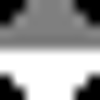
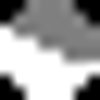
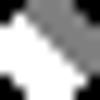
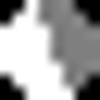
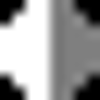
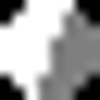
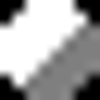
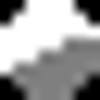
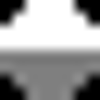
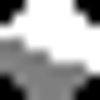
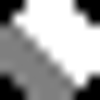
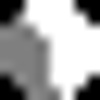
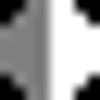
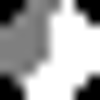
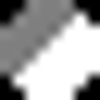
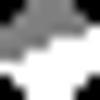

In [38]:
group_sensors_img = []
captions = []
steps = pow(SENSOR_GROUP_SIZE, 2)
sz = RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE

for i in range(steps):
    canvas = Image.new('L', (sz, sz))
    draw = ImageDraw.Draw(canvas)
    draw.ellipse([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE - 1, SENSOR_RECEPTIVE_FIELD_SIZE - 1], outline=0, fill=127, width=0)
    angle = i * 360 / steps
    draw.chord([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE - 1, SENSOR_RECEPTIVE_FIELD_SIZE - 1], angle, angle + 180, outline=255, fill=255)
    group_sensors_img.append(canvas)
    captions.append(f'#{i} ({i // SENSOR_GROUP_SIZE}, {i % SENSOR_GROUP_SIZE})')

display_images_grid(list(map(lambda x: x.crop([0,0,SENSOR_RECEPTIVE_FIELD_SIZE,SENSOR_RECEPTIVE_FIELD_SIZE]).resize((100, 100)), group_sensors_img)), col_count=SENSOR_GROUP_SIZE, captions=captions)

In [39]:
group_sensors = xp.array(list(map(xp.array, group_sensors_img))).astype(float)
shape_save = group_sensors.shape
group_sensors = group_sensors.reshape(SENSOR_GROUP_SIZE*SENSOR_GROUP_SIZE, -1)
# Due to rough granularity count of positive pixels and negative may be not eqaul => equalize via weight
group_sensors[group_sensors==255] = 1
counts_of_positives = (group_sensors == 1).sum(axis=1)
counts_of_negatives = (group_sensors == 127).sum(axis=1)
white_image = xp.ones(group_sensors.shape[1])

for i, (p, n) in enumerate(zip(counts_of_positives, counts_of_negatives)):
    assert p > 0, (i, p)
    assert n > 0, (i, n)
    group_sensors[i][group_sensors[i] == 127] = -1 * (p / n)
    v = group_sensors[i] @ white_image
    assert xp.isclose(v, 0), v

group_sensors = group_sensors.reshape(shape_save)
group_sensors.shape, np.unique_counts(xp_array_from_gpu(group_sensors))

((16, 128, 128),
 UniqueCountsResult(values=array([-1.36363636, -1.26086957, -1.16666667, -1.08      , -1.        ,
         0.        ,  1.        ]), counts=array([    44,    138,     48,     50,    104, 261312,    448])))

In [40]:
group_sensors_ones = (group_sensors.reshape(group_sensors.shape[0], -1) == 1).sum(axis=1)
group_sensors_ones, group_sensors_ones.mean(), group_sensors_ones.min(), group_sensors_ones.max(), group_sensors_ones.std()

(array([26, 27, 29, 28, 26, 28, 29, 27, 26, 29, 29, 30, 26, 30, 29, 29]),
 array(28.),
 array(26),
 array(30),
 array(1.41421356))

In [41]:
# single sensor occupies (RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE) ^ 2
# we have group of such sensors stacked under each other in a square fashion, hence SENSOR_GROUP_SIZE^2
# to cover all visual area we have RETINA_SIZE^2 of such groups
retina = xp.zeros((RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), pow(RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE, 2)))
retina = retina.reshape((RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), -1))

for y in range(RETINA_SIZE):
    for x in range(RETINA_SIZE):
        for g in range(pow(SENSOR_GROUP_SIZE, 2)):
            sensor_at_place = group_sensors[g]
            sensor_at_place = xp.roll(sensor_at_place, y * SENSOR_RECEPTIVE_FIELD_SIZE, axis=0)
            sensor_at_place = xp.roll(sensor_at_place, x * SENSOR_RECEPTIVE_FIELD_SIZE, axis=1)
            retina[y, x, g, :] = sensor_at_place.reshape(-1)

retina = retina.reshape((-1, pow(RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE, 2)))
RETINA_POS = retina
RETINA_NEG = retina.copy()

RETINA_POS[RETINA_POS < 0] = 0
RETINA_NEG[RETINA_NEG > 0] = 0


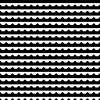
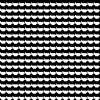
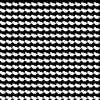
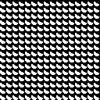
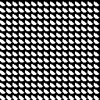
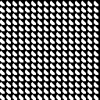
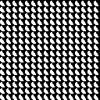
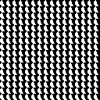
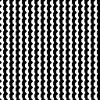
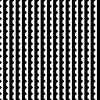
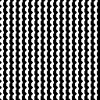
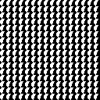
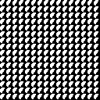
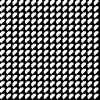
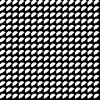
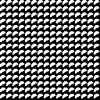
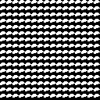
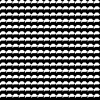
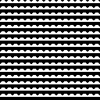
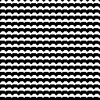
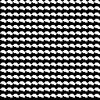
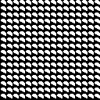
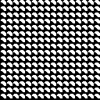
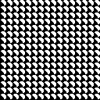
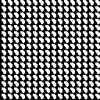
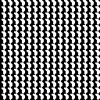
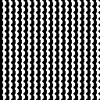
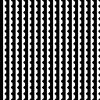
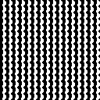
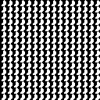
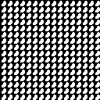
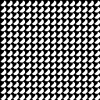
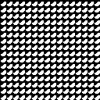
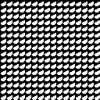
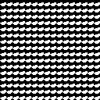
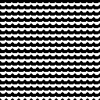

In [42]:
sz = RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE
steps = 36 # 10 degreee
specific_samples_img = []
captions = []

for i in range(steps):
    canvas = Image.new('L', (sz, sz))
    draw = ImageDraw.Draw(canvas)
    angle = i * 360 / steps
       
    draw.chord([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE - 1, SENSOR_RECEPTIVE_FIELD_SIZE - 1], angle, angle + 180, outline=255, fill=255)
    crop = canvas.crop([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE, SENSOR_RECEPTIVE_FIELD_SIZE])

    for x in range(0, sz, SENSOR_RECEPTIVE_FIELD_SIZE):
        for y in range(0, sz, SENSOR_RECEPTIVE_FIELD_SIZE):
            canvas.paste(crop, [x, y, x + SENSOR_RECEPTIVE_FIELD_SIZE, y + SENSOR_RECEPTIVE_FIELD_SIZE])
            
    specific_samples_img.append(canvas)
    captions.append(f'#{i}')

display_images_grid(list(map(lambda x: x.resize((100, 100)), specific_samples_img)), col_count=int(np.sqrt(steps)), captions=captions)

In [43]:
SPECIFIC_SAMPLES = np.array(list(map(np.array, specific_samples_img))).astype(float)
SPECIFIC_SAMPLES[SPECIFIC_SAMPLES==255] = 1
SPECIFIC_SAMPLES = SPECIFIC_SAMPLES.reshape(SPECIFIC_SAMPLES.shape[0], -1)
SPECIFIC_SAMPLES.shape, np.unique_counts(SPECIFIC_SAMPLES)

((36, 16384),
 UniqueCountsResult(values=array([0., 1.]), counts=array([331776, 258048])))

In [44]:
assert np.array_equal(np.unique(SPECIFIC_SAMPLES), [0, 1])

specific_samples_sense_pos = RETINA_POS @ xp_array_to_gpu(SPECIFIC_SAMPLES.T)
specific_samples_sense_neg = RETINA_NEG @ xp_array_to_gpu(SPECIFIC_SAMPLES.T)
specific_samples_sense_pos = specific_samples_sense_pos.reshape(RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), -1)
specific_samples_sense_neg = specific_samples_sense_neg.reshape(RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), -1)
specific_samples_sense_ref = specific_samples_sense_pos.copy() # reference
assert specific_samples_sense_pos.shape == specific_samples_sense_neg.shape

# Base for calculations = AREA of illumination must be at least 1/2 of area of positive receptors
# Next we exclude sensors which do not minimal LEVEL of illumination = area * (255 * 10%)
# Finally we exclude sensors which do not have enough contrast (DIFF) - use NEG part of retina and use logarithmic scale (dB)
# For specific samples situation is more straighforward, since its liminiscense is binary (0 or 1)
for y in range(specific_samples_sense_ref.shape[0]):
    for x in range(specific_samples_sense_ref.shape[1]):
        # Matrix of how each group of sensors (rows) perceives each of specific samples (columns)
        perceive_matrix = specific_samples_sense_ref[y, x]
        assert perceive_matrix.shape == (pow(SENSOR_GROUP_SIZE, 2), SPECIFIC_SAMPLES.shape[0])
        cond1 = (perceive_matrix.T / group_sensors_ones).T >= 0.5 # At least half of a positive area of each of sensors is activated

        perceive_matrix_pos = specific_samples_sense_pos[y, x]
        perceive_matrix_neg = xp.abs(specific_samples_sense_neg[y, x])
        assert perceive_matrix_pos.shape == perceive_matrix.shape
        assert perceive_matrix_neg.shape == perceive_matrix.shape

        cond2 = perceive_matrix_pos > perceive_matrix_neg # There is more activation on positive areas than on negative
        assert cond1.shape == cond2.shape
        specific_samples_sense_ref[y, x] = (cond1 & cond2).astype(float)

specific_samples_sense_ref = xp_array_from_gpu(specific_samples_sense_ref)

In [45]:
for i in range(SPECIFIC_SAMPLES.shape[0]):
    v = specific_samples_sense_ref[0, 0, :, i]
    print(f'{v} => {(v == 1).sum()}')

    for y in range(specific_samples_sense_ref.shape[0]):
        for x in range(specific_samples_sense_ref.shape[1]):
            assert np.array_equal(v, specific_samples_sense_ref[y, x, :, i])

[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] => 7
[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] => 8
[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] => 8
[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] => 8
[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] => 8
[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.] => 8
[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.] => 8
[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] => 8
[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] => 8
[0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] => 7
[0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.] => 8
[0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.] => 8
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.] => 8
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.] => 8
[0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.] => 8
[0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.] => 8
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.] => 8
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.] => 8
[0. 0. 0. 

In [46]:
def lay_grid(image, step):
    draw = ImageDraw.Draw(image)

    for c in range(step - 1, image.height, step):
        draw.line([0, c, image.width, c], fill=127)
        draw.line([c, 0, c, image.height], fill=127)

    return image

In [47]:
MINIMAL_ILLUMINATION_ABS_LEVEL = 255 * 0.1
MINIMAL_ILLUMINATION_DIFF_DB = 2 # dB
MINIMAL_ILLUMINATION_DIFF_RATIO = pow(10, MINIMAL_ILLUMINATION_DIFF_DB/20)

def sense_images(images, active_sensors=None):
    active_sensors = xp.ones((RETINA_SQUARE * SENSOR_GROUP_SQUARE, 1)) if active_sensors is None else active_sensors
    assert active_sensors.shape == (RETINA_POS.shape[0], 1)
    sense_ress = []
    image_masks = images.copy()
    image_masks[image_masks > 0] = 1

    effective_retina_pos = RETINA_POS * active_sensors
    effective_retina_neg = RETINA_NEG * active_sensors
    sense_area = (effective_retina_pos @ image_masks.T).T # for check of illuminated area
    sense_level = (effective_retina_pos @ images.T).T # for check of absolute illumination
    sense_neg_level = (effective_retina_neg @ images.T).T # for check of relative diff

    assert sense_area.shape == (len(images), RETINA_SQUARE * SENSOR_GROUP_SQUARE), sense_area.shape
    assert sense_area.shape == sense_level.shape
    assert sense_area.shape == sense_neg_level.shape
    
    # Base for calculations = AREA of illumination must be at least 1/2 of area of positive receptors
    # Next we exclude sensors which do not minimal LEVEL of illumination = area * (255 * 10%)
    # Finally we exclude sensors which do not have enough contrast (DIFF) - use NEG part of retina and use logarithmic scale (dB)
    for sense_area_i, sense_level_i, sense_neg_level_i in zip(sense_area, sense_level, sense_neg_level):
        sense_area_i = sense_area_i.reshape(-1, 16)
        cond1 = (sense_area_i / group_sensors_ones) >= 0.5 # At least half of a positive area of each of sensors is activated
        cond1 = cond1.reshape(-1,)
    
        sense_level_i = sense_level_i.reshape(-1, 16)
        sense_level_i[sense_level_i <= 0] = 1e-6 # to ease cond3
        cond2 = (sense_level_i > MINIMAL_ILLUMINATION_ABS_LEVEL * group_sensors_ones) # Illumination level of an area must exceed given threshold
        cond2 = cond2.reshape(-1,)
    
        sense_neg_level_i = xp.abs(sense_neg_level_i)
        sense_neg_level_i[sense_neg_level_i <= 0] = 1e-6 # to ease cond3
        cond3 = (sense_level_i.reshape(-1,) / sense_neg_level_i) >= MINIMAL_ILLUMINATION_DIFF_RATIO # Illumination of positive area must be > illumination of negative one
    
        sense_res = (cond1 & cond2 & cond3).astype(int) # mask of active sensors for particular image
        sense_ress.append(sense_res)

    return xp.array(sense_ress)

In [48]:
def get_grid_offsets(lo, hi):
    assert hi > lo
    points = []
    rng = range(lo, hi + 1)
    
    for i in rng:
        for j in rng:
            if i == 0 and j == 0:
                continue
                
            points.append((i,j))
    
    return np.array(points)

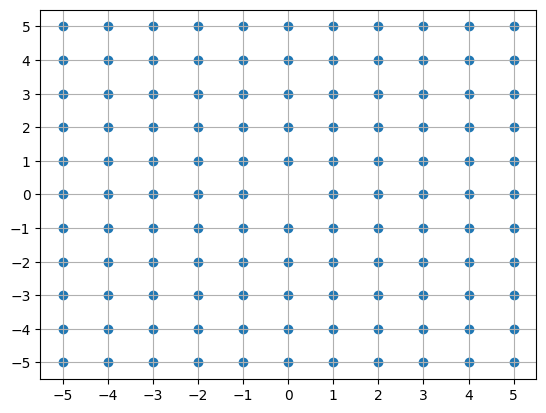

(120, 2)

In [49]:
points = get_grid_offsets(-5, 5)
plt.scatter(points[:,0], points[:,1])
plt.xticks(range(np.min(points[:,0]), np.max(points[:,0]) + 1, 1))
plt.yticks(range(np.min(points[:,1]), np.max(points[:,1]) + 1, 1))
plt.grid()
plt.show()
points.shape

In [50]:
def get_clock_offsets(radiuses):
    assert np.all(np.array(radiuses) > 0)
    hours = 12
    rotation_transfs = []
    
    for i in range(hours):
        theta = (2 * math.pi / hours) * i
        cos_theta = math.cos(theta)
        sin_theta = math.sin(theta)
        transf = [
            [cos_theta, sin_theta, 0],
            [-sin_theta, cos_theta, 0],
            [0, 0, 1]
        ]
        rotation_transfs.append(np.array(transf))
    
    rotation_transfs = np.array(rotation_transfs)
    points = dict()
    
    for radius in radiuses:
        arrow = np.array([radius, 0, 0])
        arrow_positions = (rotation_transfs @ arrow).astype(int)
        # duplicates handling
        arrow_positions_codes = [''.join(map(str, ap)) for ap in arrow_positions]
        points.update(zip(arrow_positions_codes, arrow_positions))
    
    if '000' in points: 
        del points['000']

    return np.array(list(points.values()))[:,0:2]

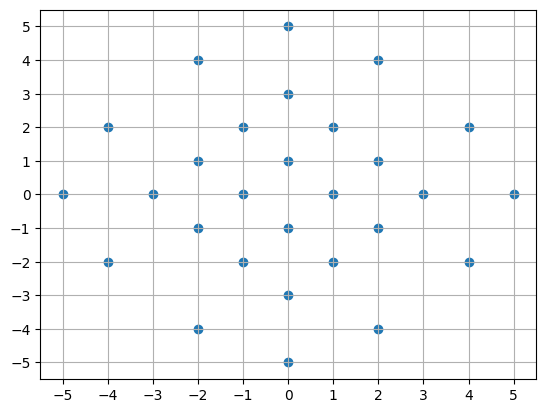

(28, 2)

In [51]:
radiuses = [5, 3, 1]
points = get_clock_offsets(radiuses)
plt.grid()
plt.scatter(points[:,0], points[:,1])
plt.xticks(range(np.max(radiuses) * -1, np.max(radiuses) + 1, 1))
plt.yticks(range(np.max(radiuses) * -1, np.max(radiuses) + 1, 1))
plt.show()
points.shape

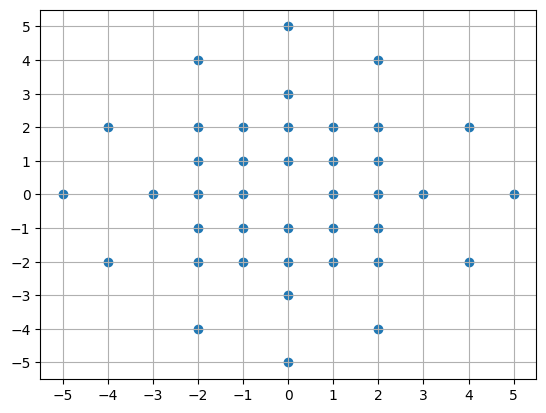

(40, 2)

In [52]:
points1 = get_grid_offsets(-2, 2)
points2 = get_clock_offsets([5, 3])
points = np.array(list(set(map(lambda x: (int(x[0]), int(x[1])), chain(points1, points2)))))
plt.grid()
plt.scatter(points[:,0], points[:,1])
plt.xticks(range(np.max(radiuses) * -1, np.max(radiuses) + 1, 1))
plt.yticks(range(np.max(radiuses) * -1, np.max(radiuses) + 1, 1))
plt.show()
points.shape

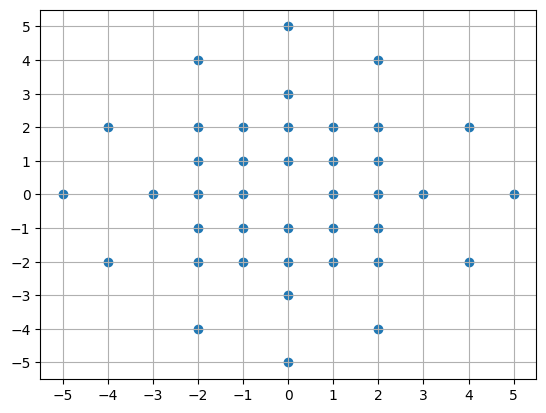

(40, 2)

In [53]:
plt.grid()
plt.scatter(points[:,0], points[:,1])
plt.xticks(range(np.max(radiuses) * -1, np.max(radiuses) + 1, 1))
plt.yticks(range(np.max(radiuses) * -1, np.max(radiuses) + 1, 1))
plt.show()
points.shape

In [54]:
def generate_image_offsets(image, offsets):
    sz = int(np.sqrt(image.shape[0]))
    assert sz * sz == image.shape[0]
    images = []

    for off in offsets:
        image_offed = image.reshape(sz, sz)

        # offset by x
        x = off[0]
        image_offed = np.roll(image_offed, x, axis=1)
        cols_to_wipeout = [min(x, 0) + i for i in range(abs(x))]
        image_offed[:,cols_to_wipeout] = 0

        # offset by y
        y = off[1]
        image_offed = np.roll(image_offed, y, axis=0)
        rows_to_wipeout = [min(y, 0) + i for i in range(abs(y))]
        image_offed[rows_to_wipeout,:] = 0
        
        image_offed = image_offed.reshape(-1)
        images.append(image_offed)

    return np.array(images)

In [55]:
def matrix_to_image(m):
    m = m.ravel()
    sz = int(np.sqrt(m.shape[0]))
    assert sz * sz == m.shape[0]
    return Image.frombytes('L', size=(sz, sz), data=m.astype('b'))


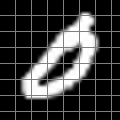
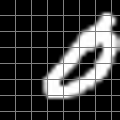
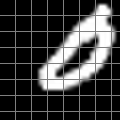
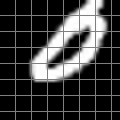
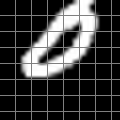
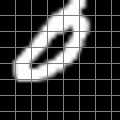
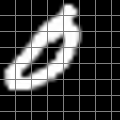
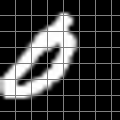
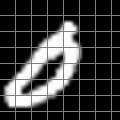
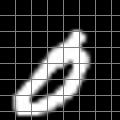
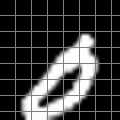
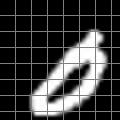
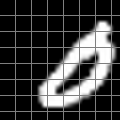
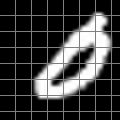
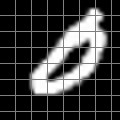
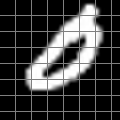
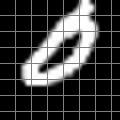
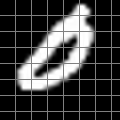
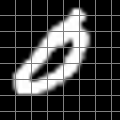
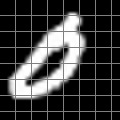
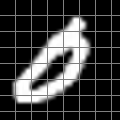
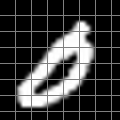
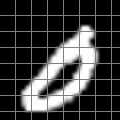
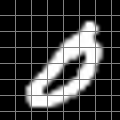
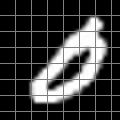
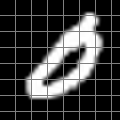
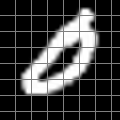
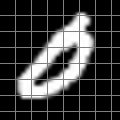
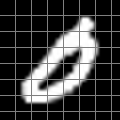

In [56]:
xy_offsets = np.concat([[[0, 0]], get_clock_offsets([5, 3, 1])])
img_data = x_train[RNG.choice(len(x_train))]

with Image.frombytes('L', size=(28, 28), data=img_data) as img:
    image_offsets = generate_image_offsets(np.array(img).ravel(), xy_offsets)

captions = list(map(lambda x: f'x={x[0]}, y={x[1]}', xy_offsets))
display_images_grid(list(map(lambda i: lay_grid(matrix_to_image(i).resize((120, 120)), 16), image_offsets)), captions=captions, col_count=8)

In [57]:
id_offset = 0

image_indices = RNG.choice(len(x_train), 10, replace=False)
image_dataset = defaultdict(list)
image_encoding_dataset = defaultdict(list)
xy_offsets = np.concat([[[0, 0]], get_clock_offsets([5, 3, 1])])

for i in tqdm(image_indices):
    img_data = x_train[i]
    img_label = y_train[i]

    with Image.frombytes('L', size=(28, 28), data=img_data) as img:
        b = io.BytesIO()
        img = img.resize((config.sample_size, config.sample_size))
        img.save(b, format='PNG')
        png = b.getvalue()

        image_id = i + id_offset
        image_dataset['image_id'].append(image_id)
        image_dataset['value'].append(str(img_label))
        image_dataset['png'].append(png)

        image_offsets = generate_image_offsets(np.array(img).ravel(), xy_offsets)
        image_offset_encodings = sense_images(xp.array(image_offsets))

        for ioe, (x, y) in zip(image_offset_encodings, xy_offsets):
            image_encoding_dataset['image_id'].append(image_id)
            image_encoding_dataset['offset_x'].append(x)
            image_encoding_dataset['offset_y'].append(y)
            image_encoding_dataset['data'].append(xp_array_from_gpu(ioe).astype('b'))

image_dataset = pd.DataFrame(image_dataset)
image_encoding_dataset = pd.DataFrame(image_encoding_dataset)
;

  0%|          | 0/10 [00:00<?, ?it/s]

''

In [58]:
def create_datasets(x_dataset, y_dataset, samples_count, id_offset):
    image_indices = RNG.choice(len(x_dataset), samples_count, replace=False)
    image_dataset = defaultdict(list)
    image_encoding_dataset = defaultdict(list)

    xy_offsets_grid = get_grid_offsets(-2, 2)
    xy_offsets_clock = get_clock_offsets([5, 3])
    xy_offsets = np.array(list(set(map(lambda x: (int(x[0]), int(x[1])), chain(xy_offsets_grid, xy_offsets_clock)))))
    xy_offsets = np.concat([[[0, 0]], xy_offsets])
    
    for i in tqdm(image_indices):
        img_data = x_dataset[i]
        img_label = y_dataset[i]
    
        with Image.frombytes('L', size=(28, 28), data=img_data) as img:
            b = io.BytesIO()
            img = img.resize((config.sample_size, config.sample_size))
            img.save(b, format='PNG')
            png = b.getvalue()
    
            image_id = i + id_offset
            image_dataset['image_id'].append(image_id)
            image_dataset['value'].append(str(img_label))
            image_dataset['png'].append(png)
    
            image_offsets = generate_image_offsets(np.array(img).ravel(), xy_offsets)
            image_offset_encodings = sense_images(xp.array(image_offsets))
    
            for ioe, (x, y) in zip(image_offset_encodings, xy_offsets):
                image_encoding_dataset['image_id'].append(image_id)
                image_encoding_dataset['offset_x'].append(x)
                image_encoding_dataset['offset_y'].append(y)
                image_encoding_dataset['data'].append(xp_array_from_gpu(ioe).astype('b'))
    
    image_dataset = pd.DataFrame(image_dataset)
    image_encoding_dataset = pd.DataFrame(image_encoding_dataset)
    return image_dataset, image_encoding_dataset

def save_datasets(image_dataset, image_encoding_dataset, db_con):
    image_dataset.to_sql(name='images', con=db_con)
    image_encoding_dataset.to_sql(name='image_encodings', con=db_con)

    cur = db_con.cursor()
    cur.execute('CREATE INDEX ix_images_image_id ON images(image_id)')
    cur.execute('CREATE INDEX ix_image_encodings_image_id ON image_encodings(image_id)')       
    cur.execute('ALTER TABLE image_encodings ADD COLUMN hdv BLOB')

In [59]:
if not is_table_exists(train_db_con, 'images'):
    image_dataset, image_encoding_dataset = create_datasets(x_train, y_train, config.dataset_train_samples_count, 0)
    save_datasets(image_dataset, image_encoding_dataset, train_db_con)

if not is_table_exists(test_db_con, 'images'):
    image_dataset, image_encoding_dataset = create_datasets(x_test, y_test, config.dataset_test_samples_count, 100_000_000)
    save_datasets(image_dataset, image_encoding_dataset, test_db_con)

In [60]:
hdc = Hdc(config.hdc_n, np)

In [73]:
ENCODING_STRIDE_WIDTH = 16

def clear_image_encoding_hdvs(db_con):
    cur = db_con.cursor()
    cur.execute('UPDATE image_encodings SET hdv=NULL')
    db_con.commit()

def make_image_encoding_hdvs(db_con, stride_hdvs):
    cur = db_con.cursor()
    df_images = pd.read_sql('SELECT image_id FROM images', con=db_con)
    
    for _, row in tqdm(df_images.iterrows(), total=len(df_images)):
        image_id = int(row['image_id'])
        df_image_encodings = pd.read_sql('SELECT "index", data FROM image_encodings WHERE image_id=:image_id AND hdv IS NULL', params={'image_id': image_id}, con=db_con)
        executemany_params = []

        for _, enc_row in df_image_encodings.iterrows():
            enc_index = int(enc_row['index'])
            encoding = np.frombuffer(enc_row['data'], dtype='b')
            encoding_stride_hdvs = []
            encoding_hdv = np.array([])
            
            for stride_index in range(0, encoding.shape[0], ENCODING_STRIDE_WIDTH):
                stride = encoding[stride_index:stride_index + ENCODING_STRIDE_WIDTH]
                stride_code = ''.join(map(str, stride.tolist()))
    
                if not stride_code.replace('0', ''): # for relatively short strides this is ~x2 faster than np.all(stride == 0) or np.max(stride) == 0
                    continue

                stride_hdv = stride_hdvs[stride_code]
                stride_hdv = hdc.shift(stride_hdv, stride_index)
                encoding_stride_hdvs.append(stride_hdv)
    
            if encoding_stride_hdvs:
                encoding_hdv = hdc.bundle(encoding_stride_hdvs)
                assert encoding_hdv.shape[0] == hdc.N, encoding_hdv.shape

            executemany_params.append({'index': enc_index, 'hdv': encoding_hdv.tobytes()})

        cur.executemany('UPDATE image_encodings SET hdv=:hdv WHERE "index"=:index', executemany_params)
    
    db_con.commit()

stride_hdvs = defaultdict(hdc)

if is_table_exists(hdv_db_con, 'stride_hdvs'):
    df_stride_hdvs = pd.read_sql('SELECT code, hdv FROM stride_hdvs', con=hdv_db_con)
    hdvs = map(lambda x: np.frombuffer(x, dtype='b'), df_stride_hdvs['hdv'])
    stride_hdvs.update(zip(df_stride_hdvs['code'], hdvs))

if 1 == 1:
    clear_image_encoding_hdvs(train_db_con)
    clear_image_encoding_hdvs(test_db_con)
    
make_image_encoding_hdvs(train_db_con, stride_hdvs)
make_image_encoding_hdvs(test_db_con, stride_hdvs)

pd.DataFrame(stride_hdvs.items(), columns=['code', 'hdv']).to_sql(name='stride_hdvs', con=hdv_db_con, if_exists='replace')

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

475

In [74]:
df_image_encodings = pd.read_sql('SELECT "index", hdv FROM image_encodings WHERE "index"=0 LIMIT 1', con=train_db_con)

for enc_index, enc_row in df_image_encodings.iterrows():
    hdv = np.frombuffer(enc_row['hdv'], dtype='b')
    print(len(enc_row['hdv']), hdv.shape, np.unique_counts(hdv))    

10000 (10000,) UniqueCountsResult(values=array([-1,  1], dtype=int8), counts=array([5114, 4886]))


CPU times: user 86.8 ms, sys: 16.1 ms, total: 103 ms
Wall time: 102 ms



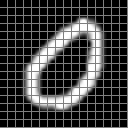
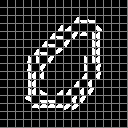
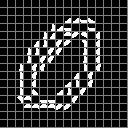
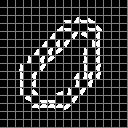
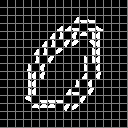
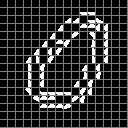
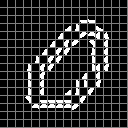
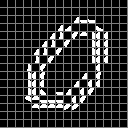
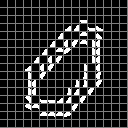
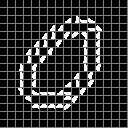
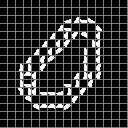
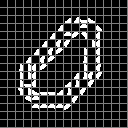
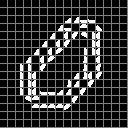
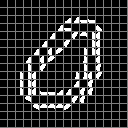
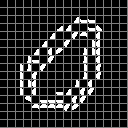
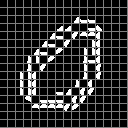
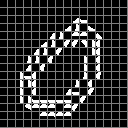
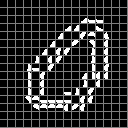
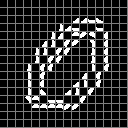
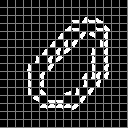
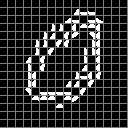
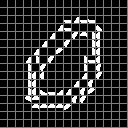
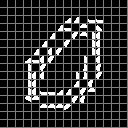
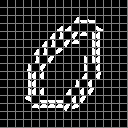
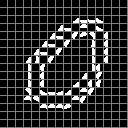
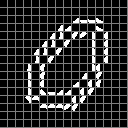
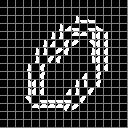
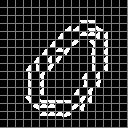
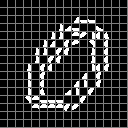
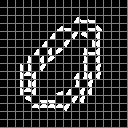
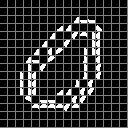
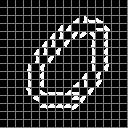
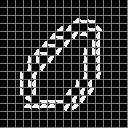
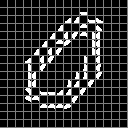
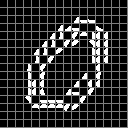
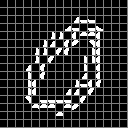
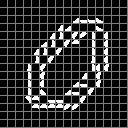
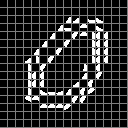
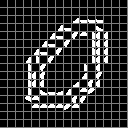
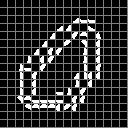
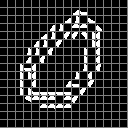
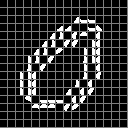

In [96]:
%%time
empty_image = Image.new('L', size=(1,1), color=255)
images = []
captions = []
col_count = 8

df_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
image_id = RNG.choice(df_images.index.unique())
image_data = df_images.loc[image_id]['png']
image = Image.open(io.BytesIO(image_data))
images.append(image)
captions.append(f'{image_id}, val={df_images.loc[image_id]['value']}')
images.extend([empty_image] * (col_count - 1))
captions.extend([''] * (col_count - 1))

df_encodings = pd.read_sql_query('SELECT * FROM image_encodings WHERE image_id = :image_id', params={'image_id': int(image_id)}, con=train_db_con)

for _, enc_row in df_encodings.iterrows():
    encoding = np.frombuffer(enc_row['data'], dtype='b')
    sensor_activations = encoding.reshape(RETINA_SIZE, RETINA_SIZE, SENSOR_GROUP_SQUARE)
    sz = RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE
    sensor_map_image = np.zeros((sz, sz))
    
    for y in range(RETINA_SIZE):
        for x in range(RETINA_SIZE):
            sensors_in_group = sensor_activations[y, x]
            assert sensors_in_group.shape == (SENSOR_GROUP_SQUARE,)
    
            if np.any(sensors_in_group > 0):
                # Find most similar reaction among specific samples of reactions
                a = sensors_in_group
                b = specific_samples_sense_ref[y, x, :]
                sense_vector_cos_sim = (a @ b)/(np.linalg.norm(a) * np.linalg.norm(b, axis=0))
                best_i = np.argmax(sense_vector_cos_sim)
                most_similar_specific_sample = SPECIFIC_SAMPLES[best_i].reshape((sz, sz))
                srfs = SENSOR_RECEPTIVE_FIELD_SIZE
                np.copyto(sensor_map_image[y*srfs:(y+1)*srfs, x*srfs:(x+1)*srfs], most_similar_specific_sample[y*srfs:(y+1)*srfs, x*srfs:(x+1)*srfs])

    images.append(Image.frombytes('L', (sz, sz), data=(sensor_map_image * 255).ravel().astype('b')))
    captions.append(f'offset={enc_row['offset_x']}, {enc_row['offset_y']}')

lay_grid_local = lambda i: lay_grid(i, SENSOR_RECEPTIVE_FIELD_SIZE)
display_images_grid(list(map(lay_grid_local, images)), captions=captions, col_count=col_count)